In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

import pandas as pd
from datetime import datetime

import os

import tkinter as tk
from tkinter import filedialog as fd

from docxtpl import DocxTemplate
import docxtpl
from docx.shared import Mm
import requests

import collections

In [2]:
# ruta de carpera donde estan las llaves
ruta = open('../ruta.txt')
ruta = ruta.readlines()[0]

## Leer catastro

In [3]:
# open file dialog
root = tk.Tk()
root.attributes('-topmost', True)
root.iconify()
file_name = fd.askopenfilename(parent=root, filetypes=[(".shp", ".shp")])
root.destroy()

In [4]:
file_name

'G:/OneDrive - Ingenio Azucarero Guabira S.A/INFORMACION GENERAL/CATASTRO/LOTES_HUBBAUER.shp'

In [5]:
# leer el .shp seleccionado
catastro = gpd.read_file(file_name)

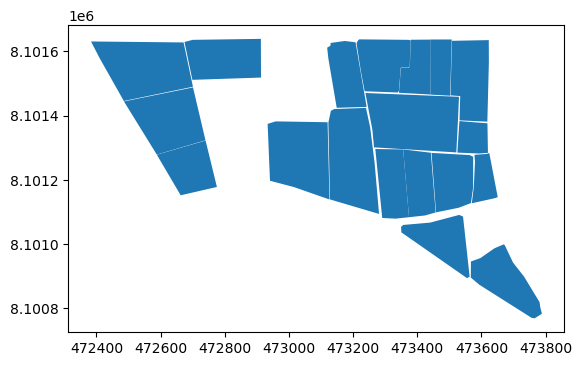

In [6]:
catastro.plot()
plt.show()

## Leer data excel

In [7]:
# open file dialog
root = tk.Tk()
root.attributes('-topmost', True)
root.iconify()
file_name = fd.askopenfilename(parent=root, filetypes=[(".xlsx", ".xlsx")])
root.destroy()

In [8]:
file_name

'G:/Ingenio Azucarero Guabira S.A/UTEA - SEMANAL - AVANCE COSECHA/2023/ANALISIS DE CAÑA EN CAMPO 2023/CENTRALIZADOR/DATA/ESTIMATIVAS_DB_V13.xlsx'

In [9]:
data_cod_cosecha = pd.read_excel(file_name, 'CODIGOS COSECHA')

In [10]:
data_cod_cosecha.head(3)

,CODIGO \nCAÑERO,INS,NOMBRE CAÑERO,CODIGO \nCOSECHA
0,515,50,AGUILERA OLGA RIVERO VDA DE,1
1,790,69,AGUILERA RIVERO JESSICA BEATRIZ,1
2,1215,50,AGUILERA RIVERO OLGA KARINA,1


## Leer codigos de grupo

In [11]:
# lista de grupo cañero
canheros = [5421]

In [12]:
# lista de propiedades de grupo cañerp
propiedades = [187]

In [13]:
# cargar datos de cañeros
lista_ca = []
for i in canheros:
    cod_ca = data_cod_cosecha[data_cod_cosecha['CODIGO \nCAÑERO '] == i].iloc[0]['CODIGO \nCAÑERO ']
    nom_ca = data_cod_cosecha[data_cod_cosecha['CODIGO \nCAÑERO '] == i].iloc[0]['NOMBRE CAÑERO']
    dict_ca = { 'cod_ca' : cod_ca, 'nom_ca' : nom_ca }
    lista_ca.append(collections.namedtuple("canhero", dict_ca.keys())(*dict_ca.values()))
lista_ca

[canhero(cod_ca=5421, nom_ca='HUBBAUER HOYOS ENRIQUE')]

In [14]:
# crear diccionario con datos de cañeros y propiedades
fecha = datetime.now()
fecha = fecha.strftime("%d/%m/%Y")
datos_ca = { 'fecha' : fecha, 'cite': 1, 'ca' : lista_ca}

In [15]:
data = collections.namedtuple("insp", datos_ca.keys())(*datos_ca.values())
data

insp(fecha='18/10/2023', cite=1, ca=[canhero(cod_ca=5421, nom_ca='HUBBAUER HOYOS ENRIQUE')])

In [16]:
total_hoja = 0
total_soca = 0
total_renov = 0
total_produc = 0
total_cultivado = 0
props_obj = []
for i in propiedades:
    propiedad = catastro[catastro['unidad_01']==i]
    cod_prop = propiedad.iloc[0]['unidad_01']
    nom_prop = propiedad.iloc[0]['unidad_02'].replace('_', ' ').split('--')[0]
    hoja = propiedad[propiedad['soca']==0]['area'].sum()
    soca = propiedad[(propiedad['soca']!=0) & (propiedad['variedad']!='RENOVACION')]['area'].sum()
    renov = propiedad[propiedad['variedad']=='RENOVACION']['area'].sum()
    produc = hoja + soca
    cultivado = hoja + soca + renov
    
    total_hoja += hoja
    total_soca += soca
    total_renov += renov
    total_produc += produc
    total_cultivado += cultivado
    
    # seleccionar las columnas
    prop_data = propiedad[['unidad_05', 'area', 'variedad', 'fs', 'soca', 'textura']]
    # cambiar nombre de comlumnas
    prop_table = prop_data.rename(columns={'unidad_05':'lote', 'area':'area', 'variedad':'variedad', 'fs':'fs', 'soca':'corte', 'textura':'textura'})
    # truncar a dos decimales
    prop_table['area'] = prop_table['area'].round(decimals=2)
    # formato de fecha
    prop_table['fs'] = pd.to_datetime(prop_table['fs']).dt.strftime('%d/%m/%Y')
    
    lista_lotes = []
    for i in range(len(prop_table)):
        lote = prop_table.iloc[i].to_dict()
        if(lote['variedad'] == 'RENOVACION'):
            lote['fs'] = ''
            lote['corte'] = ''
        lote = collections.namedtuple("lote", lote.keys())(*lote.values())
        lista_lotes.append(lote)
    
    propiedad_dict = { 
        'cod_prop' : cod_prop,
        'nom_prop' : nom_prop,
        'hoja' : hoja, 
        'soca' : soca, 
        'renov' : renov,
        'produc' : produc,
        'cultivado' : cultivado,
        'lotes' : lista_lotes}
    props_obj.append(collections.namedtuple("propiedad", propiedad_dict.keys())(*propiedad_dict.values()))

In [17]:
totales = { 
    't_hoja': total_hoja,
    't_soca' : total_soca,
    't_renov' : total_renov,
    't_produc': total_produc,
    't_cultivado' : total_cultivado}

In [18]:
total = collections.namedtuple("total", totales.keys())(*totales.values())

In [19]:
doc = DocxTemplate(ruta+"/templates/tpl_informe_banco.docx")
context = {'insp' : data, 'propiedades' : props_obj, 'total' : total}
doc.render(context)
file_name = 'ff'
doc.save('_' + file_name + '.docx')